In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import HoltWintersResults

### FLOW:

This is a simple time series analysis on the dataset that represents retail sales in various categories for different Australian states. After examination of the dataset, different smoothing techniques to detrend and deseasonalize the turnover data.

In [3]:
retail_data = pd.read_excel("retail.xlsx")

##### When data is observed, the first row is series ID which is reduntant. Also, Unnamed: 0 column should be set as index:

In [4]:
retail = retail_data.iloc[1:,:].set_index("Unnamed: 0")

In [5]:
retail_1 = retail[["Turnover ;  New South Wales ;  Other retailing n.e.c. ;"]].copy()

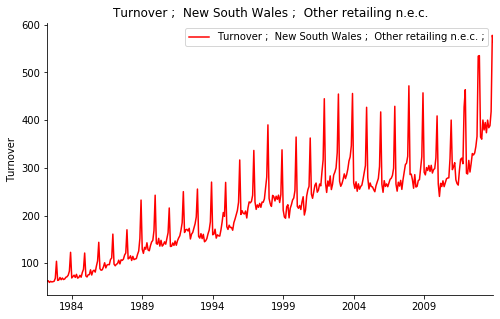

In [10]:
fig, ax= plt.subplots(figsize=(8,5))
retail_1.plot(color='red',ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Turnover')
ax.set_title('Turnover ;  New South Wales ;  Other retailing n.e.c.')
ax.set_xticks([], minor=True) 
sns.despine()
plt.show()

#### We need multiplicative seasonality since the seasonal variation in the data increases with time.

#### The seasonality seems to be annual. Since variation increases over time we can use box_cox transformation as well. Below, damped and undamped version fits are created and compared. 

In [20]:
y = retail_1["Turnover ;  New South Wales ;  Other retailing n.e.c. ;"].astype(float)
index = retail_1.index
to_be_fitted = pd.Series(y, index)

In [21]:
fit_undamped = ExponentialSmoothing(to_be_fitted,seasonal_periods=12,trend='add',seasonal="mul",damped=False)\
               .fit(use_boxcox=True)

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [22]:
fit_damped = ExponentialSmoothing(to_be_fitted,seasonal_periods=12,trend='add',seasonal="mul",damped=True)\
               .fit(use_boxcox=True)

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


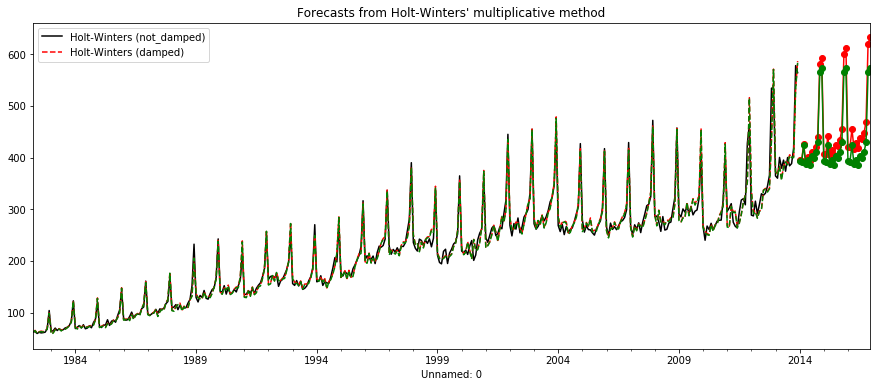

In [61]:
fig, ax = plt.subplots(figsize=(15,6))

to_be_fitted.plot(ax=ax, color='black', title="Forecasts from Holt-Winters' multiplicative method" )
fit_undamped.fittedvalues.plot(ax=ax, style='--', color='red')
fit_damped.fittedvalues.plot(ax=ax, style='--', color='green')

fit_undamped.forecast(36).rename('Holt-Winters (not_damped)').plot(ax=ax, marker='o', color='red', legend=True)
fit_damped.forecast(36).rename('Holt-Winters (damped)').plot(ax=ax, marker='o', color='green', legend=True)

plt.show()

In [54]:
symbols = [r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE","RMSE"]
parameters = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']

In [56]:
results_df = pd.DataFrame(index=symbols)
results_df["Undamped"] = [round(fit_undamped.params[p],4) for p in parameters] + [fit_undamped.sse,np.mean(abs(fit_undamped.resid)**2)] + []
results_df["Damped"] = [round(fit_damped.params[p],4) for p in parameters] + [fit_damped.sse,np.mean(abs(fit_damped.resid)**2)]

In [57]:
results_df

,Undamped,Damped
$\alpha$,0.542000,0.567100
$\beta$,0.000000,0.149800
$\phi$,NaN,0.000000
$\gamma$,0.386600,0.387900
$l_0$,30.011000,30.012000
$b_0$,0.135600,0.000000
SSE,67886.315788,68356.449551
RMSE,178.179307,179.413253


#### When SSE and mean squared residuals are examined undamped version seems to be performing better. Therefore, I prefer undamped model with the equation:


- Forecast p periods into the future
Yt+h = (Lt + h*Tt) * St+h-m

- exponentially smoothed series or level estimate
Lt=0.542*Yt/St-m + (1-0.542)*(Lt-1 + Tt-1)
- The trend estimate
Tt=0*(Lt- Lt-1) + (1-0)*Tt-1
- The seasonality estimate
St=0.387*Yt/(Lt-1 + Tt-1) + (1-0.387)*St-m

where h = 12

#### Residuals seem as white noise.

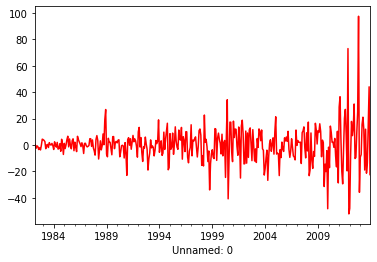

In [63]:
fit_undamped.resid.plot(color="red")

#### To detrend and deseason the data, we should apply several methods. First would be to transform the data to diminish the increasing variance, and deseason & detrend:

##### Lets see autocorrelation and partial autocorrelation graphs to make sure of the data:

When we examine the plots we see a trend and seasonality at lags 12 (annual):

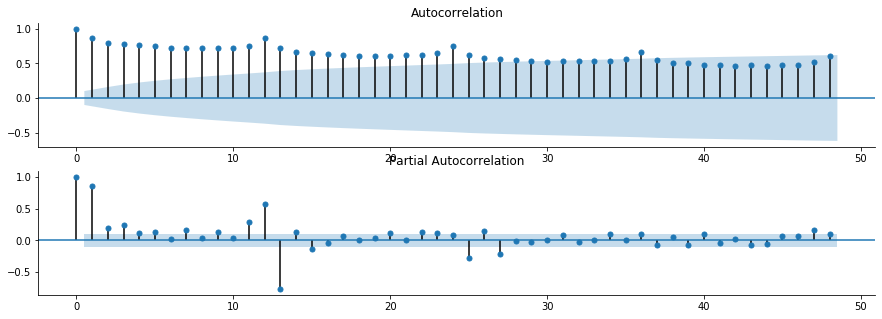

In [68]:
fig, axes = plt.subplots(nrows=2,figsize=(15,5))
sm.graphics.tsa.plot_acf(y, lags=48, ax=axes[0])
sm.graphics.tsa.plot_pacf(y, lags=48, ax=axes[1])
sns.despine()
plt.show()

In [69]:
transf,lambda_1,ConfInt=stats.boxcox(y,alpha=0.05)
print(lambda_1)

0.5446735002971659


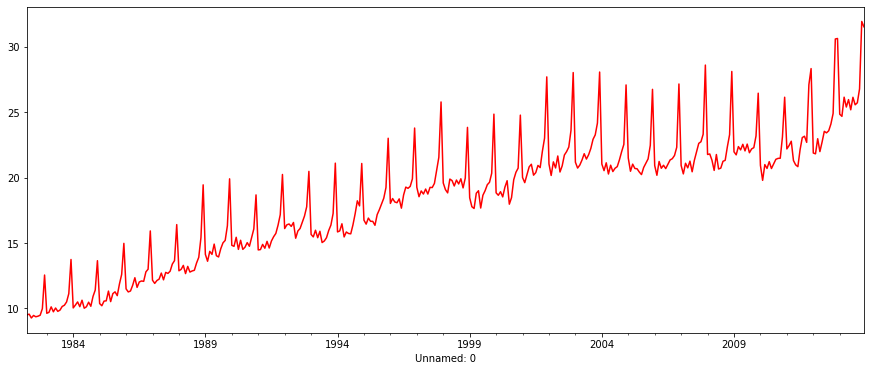

In [75]:
y_tf = np.power(y,lambda_1)
fig, ax= plt.subplots(figsize=(15,6))
y_tf.plot(ax=ax,color="red")
plt.show()

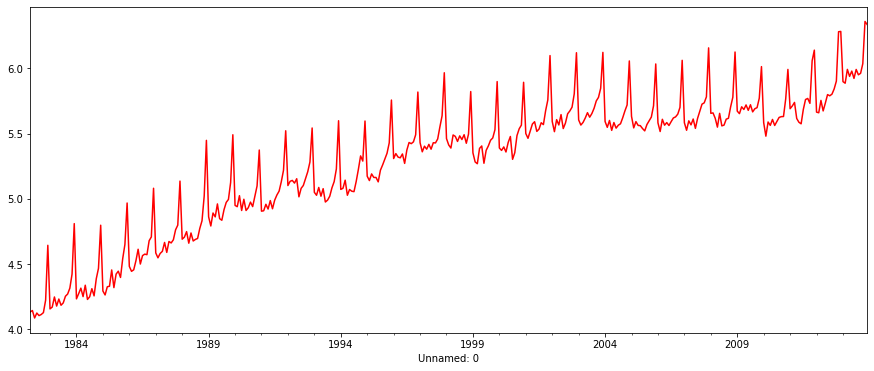

In [97]:
y_log = np.log(y)
fig, ax= plt.subplots(figsize=(15,6))
y_log.plot(ax=ax,color="red")
plt.show()

##### log transformation seems to be stabilizing variation:

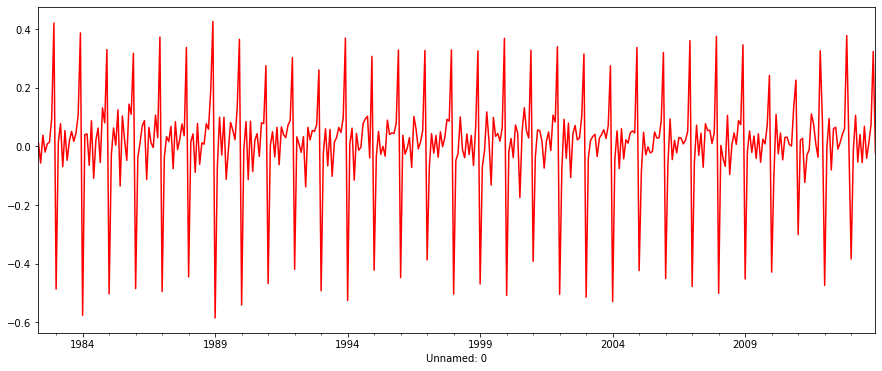

In [98]:
t_diff = (y_log-y_log.shift(1)).dropna()
fig, ax= plt.subplots(figsize=(15,6))
t_diff.plot(color="red")

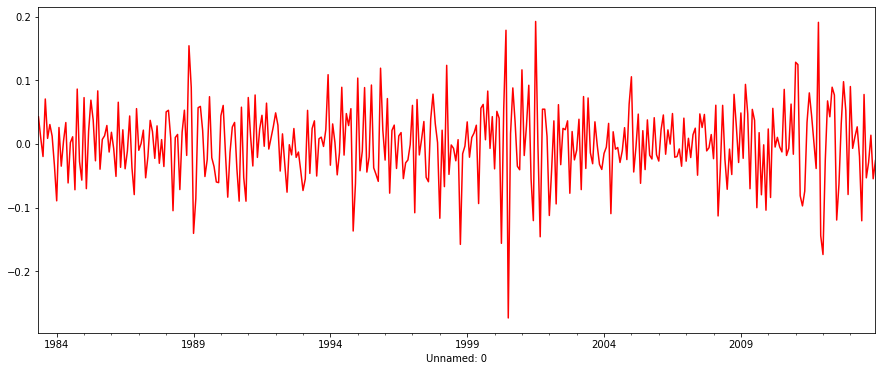

In [99]:
s_diff = (t_diff-t_diff.shift(12)).dropna()
fig, ax= plt.subplots(figsize=(15,6))
s_diff.plot(color="red")

In [100]:
import statsmodels
statsmodels.tsa.stattools.kpss(s_diff, lags=12)

C:\Users\okana\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.01812271696313576,
 0.1,
 12,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

##### So, log transformation, differencing by 1 and 12 is enough to make the data stationary